In [ ]:
! pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import librosa
import os
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
import jiwer

In [ ]:
# 1. Load Data
csv_file_path = '/content/drive/MyDrive/databaru/50transkrip.csv'
audio_folder_path = '/content/drive/MyDrive/databaru/dataAudio16Hz'

In [ ]:
# Load the CSV and remove unnecessary columns
csv_data = pd.read_csv(csv_file_path)
csv_data = csv_data.drop(columns=['indo'])

# Menyusun data audio dan transkripsi
audio_files = []
transcriptions = []

for index, row in csv_data.iterrows():
    filename = row['filename']
    audio_file_path = os.path.join(audio_folder_path, f"{filename}")
    if os.path.exists(audio_file_path):
        audio_files.append(audio_file_path)
        transcriptions.append(row['bugis'])

# Membagi data menjadi 80% data latih dan 20% data sementara (uji + validasi)
X_train, X_temp, y_train, y_temp = train_test_split(audio_files, transcriptions, test_size=0.2, random_state=42)

# Membagi data sementara (X_temp, y_temp) menjadi 50% data uji dan 50% data validasi
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 0.5 * 0.2 = 0.1


In [ ]:
# Tampilkan data awal
print(csv_data.head())

       filename                        bugis
0  1_copy_1.wav  makenni maneng mopa manu'ku
1  1_copy_2.wav  makenni maneng mopa manu'ku
2  1_copy_3.wav  makenni maneng mopa manu'ku
3  1_copy_4.wav  makenni maneng mopa manu'ku
4  1_copy_5.wav  makenni maneng mopa manu'ku


Gabungan

In [ ]:
import librosa
import numpy as np

# Set the desired time steps and number of mel bands
desired_time_steps = 7
desired_n_mels = 128 # Corrected from 141 to match model input
desired_n_mfcc = 13  # Jumlah MFCC yang diinginkan (biasanya 12-13)

def extract_audio_features(file_path, max_length=desired_time_steps):
    audio, sr = librosa.load(file_path, sr=None)  # Load with original sampling rate

    # Ekstrak Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, n_mels=desired_n_mels, fmax=sr/2)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Ekstrak MFCC
    # Adjusting hop_length to potentially help with consistent time steps, although padding/truncation should handle it
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=desired_n_mfcc, n_fft=2048, hop_length=512)

    # Transpose Mel-spectrogram and MFCC
    mel_spec = mel_spec.T
    mfcc = mfcc.T

    # Ensure the time steps dimension is max_length (7) for both mel_spec and mfcc
    if mel_spec.shape[0] < max_length:
        pad_width = max_length - mel_spec.shape[0]
        mel_spec = np.pad(mel_spec, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
    elif mel_spec.shape[0] > max_length:
        mel_spec = mel_spec[:max_length, :]

    if mfcc.shape[0] < max_length:
        pad_width = max_length - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
    elif mfcc.shape[0] > max_length:
        mfcc = mfcc[:max_length, :]

    # Ensure the n_mels and n_mfcc dimensions are correct
    if mel_spec.shape[1] < desired_n_mels:
        pad_width = desired_n_mels - mel_spec.shape[1]
        mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    elif mel_spec.shape[1] > desired_n_mels:
        mel_spec = mel_spec[:, :desired_n_mels]

    if mfcc.shape[1] < desired_n_mfcc:
        pad_width = desired_n_mfcc - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    elif mfcc.shape[1] > desired_n_mfcc:
        mfcc = mfcc[:, :desired_n_mfcc]

    # Concatenate Mel-spectrogram and MFCC features along the last axis
    # Ensure both mel_spec and mfcc have the same number of time steps before concatenating
    # This check is redundant now that we ensure max_length time steps above
    # min_time_steps = min(mel_spec.shape[0], mfcc.shape[0])
    # mel_spec = mel_spec[:min_time_steps, :]
    # mfcc = mfcc[:min_time_steps, :]

    combined_features = np.concatenate((mel_spec, mfcc), axis=-1)

    # Ensure the final output shape is exactly (max_length, desired_n_mels + desired_n_mfcc)
    # This should be handled by the padding/truncation above, but as a final check:
    target_feature_dim = desired_n_mels + desired_n_mfcc
    if combined_features.shape != (max_length, target_feature_dim):
        # This should ideally not happen with the padding/truncation logic above,
        # but as a safeguard, we can resize if necessary (though padding/truncation is preferred)
        # print(f"Warning: Feature shape mismatch for {file_path}. Expected ({max_length}, {target_feature_dim}), got {combined_features.shape}")
        # Attempt to resize, padding with zeros if smaller, truncating if larger
        resized_features = np.zeros((max_length, target_feature_dim))
        min_rows = min(combined_features.shape[0], max_length)
        min_cols = min(combined_features.shape[1], target_feature_dim)
        resized_features[:min_rows, :min_cols] = combined_features[:min_rows, :min_cols]
        combined_features = resized_features


    return combined_features

# Memuat dan mengekstrak fitur untuk data latih, validasi, dan uji
X_train_features = [extract_audio_features(f) for f in X_train]
X_val_features = [extract_audio_features(f) for f in X_val]
X_test_features = [extract_audio_features(f) for f in X_test]

# Menampilkan hasil ekstraksi fitur
print("Feature extraction re-executed.")

Feature extraction re-executed.


In [ ]:
# 3. Tokenisasi Transkripsi
tokenizer = Tokenizer()
tokenizer.fit_on_texts(transcriptions)

y_train_tokenized = tokenizer.texts_to_sequences(y_train)
y_val_tokenized = tokenizer.texts_to_sequences(y_val)
X_test_tokenized = tokenizer.texts_to_sequences(y_test)

# Determine the target sequence length based on the model's output shape
# The model's output sequence length is the same as the input audio feature's time steps (7)
target_sequence_length = 7 # This should match the model's output sequence length (7)

# Padding untuk memastikan panjangnya seragam
y_train_tokenized = tf.keras.preprocessing.sequence.pad_sequences(y_train_tokenized, padding='post', maxlen=target_sequence_length)
y_val_tokenized = tf.keras.preprocessing.sequence.pad_sequences(y_val_tokenized, padding='post', maxlen=target_sequence_length)
y_test_tokenized = tf.keras.preprocessing.sequence.pad_sequences(X_test_tokenized, padding='post', maxlen=target_sequence_length)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define vocab size based on your tokenizer
vocab_size = len(tokenizer.word_index) + 1  # plus one for padding

# Define desired_n_mels and desired_n_mfcc here to ensure they are defined
desired_n_mels = 128
desired_n_mfcc = 13

# Adjust input shape to match the extracted features (time_steps, n_mels + n_mfcc)
feature_dimension = desired_n_mels + desired_n_mfcc # 128 + 13 = 141
inputs = layers.Input(shape=(desired_time_steps, feature_dimension))  # Sesuaikan dengan 7 timesteps dan 141 fitur per timestep (Mel-spectrogram + MFCC)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(inputs)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
output = layers.Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=inputs, outputs=output)


model.summary()  # Menampilkan model setelah dibangun

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7, 141)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 7, 256)         │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 7, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 7, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7, 157)         │        40,349 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,105,309 (4.22 MB)

 Trainable params: 1,105,309 (4.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import matplotlib.pyplot as plt

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
# Reshape the input data to match the model's expected input shape (batch_size, time_steps, features)
# The combined features should have shape (7, desired_n_mels + desired_n_mfcc)
feature_dimension = desired_n_mels + desired_n_mfcc # 128 + 13 = 141
# Convert the list of feature arrays to a single numpy array.
# numpy will infer the shape from the consistent shapes of the arrays in the list.
X_train_features_reshaped = np.array(X_train_features)
X_val_features_reshaped = np.array(X_val_features)

history = model.fit(X_train_features_reshaped, np.expand_dims(y_train_tokenized, -1),
                    epochs=500, batch_size=32, validation_data=(X_val_features_reshaped, np.expand_dims (y_val_tokenized, -1)), verbose=1,
          callbacks=[EarlyStopping(
                        monitor='val_accuracy',
                        patience=5,
                        restore_best_weights=True
                    )
            ])

# history = model.fit(X_train_features_reshaped, np.expand_dims(y_train_tokenized, -1),
#                     epochs=10, batch_size=32,
#                     validation_data=(X_val_features_reshaped, np.expand_dims(y_val_tokenized, -1)))

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.3307 - loss: 3.7729 - val_accuracy: 0.3743 - val_loss: 2.8539
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3905 - loss: 2.7043 - val_accuracy: 0.4531 - val_loss: 2.2761
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5074 - loss: 2.0330 - val_accuracy: 0.6023 - val_loss: 1.6814
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6840 - loss: 1.4483 - val_accuracy: 0.7023 - val_loss: 1.3164
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7970 - loss: 1.0379 - val_accuracy: 0.8217 - val_loss: 0.9721
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8529 - loss: 0.8178 - val_accuracy: 0.8526 - val_loss: 0.8348
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8745 - loss: 0.6728 - val_accuracy: 0.8760 - val_loss: 0.7135
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8936 - loss: 0.5671 - val_accuracy: 0.

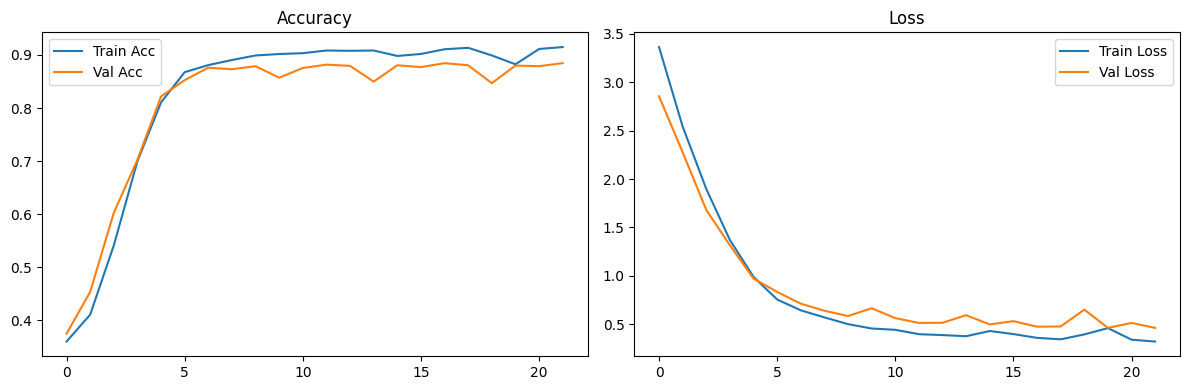

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 7. Inferensi Sederhana: Prediksi Teks dari Audio
def predict_audio_to_text(model, audio_file):
    feature = extract_audio_features(audio_file)
    feature = np.expand_dims(feature, axis=0)  # batch dimension

    pred = model.predict(feature)
    # The model outputs a sequence of length 80, so we need to decode this sequence
    pred = np.argmax(pred, axis=-1)

    # Decode the prediction to text
    pred_text_list = []
    for seq in pred:
        # Decode each sequence, excluding padding (assuming padding token is 0)
        # Need to handle the case where the prediction sequence length is 80
        decoded_seq = [tokenizer.index_word.get(idx, '') for idx in seq if idx != 0]
        pred_text_list.append(' '.join(decoded_seq)) # Join words with space

    return pred_text_list[0]


# Uji Inferensi dengan satu audio
audio_file_path = X_val[9]  # Mengambil file audio pertama dari validation set
predicted_text = predict_audio_to_text(model, audio_file_path)
print(f"Predicted text: {predicted_text}")
print(f"Actual text: {y_val[9]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
Predicted text: aleng ka ero sanggang e
Actual text: aleng ka ero sanggang e


In [ ]:
import random
import numpy as np

# Fungsi untuk melihat hasil dari 10 audio acak
def predict_multiple_audio_to_text(model, audio_files, actual_texts, tokenizer, num_samples=10):
    # Pilih 10 audio acak dari data validasi
    random_indices = random.sample(range(len(audio_files)), num_samples)

    predicted_texts = []
    actual_texts_subset = []

    # Process predictions for 10 random audio files
    for idx in random_indices:
        audio_file = audio_files[idx]
        actual_text = actual_texts[idx]

        # Make prediction for one audio file using the predict_audio_to_text function from cell l4f9eZXcxotF
        predicted_text = predict_audio_to_text(model, audio_file)

        # Store prediction results and actual texts
        predicted_texts.append(predicted_text)
        actual_texts_subset.append(actual_text)

    # Display prediction results and actual texts
    for i in range(num_samples):
        print(f"Audio {i + 1}:")
        print(f"Predicted text: {predicted_texts[i]}")
        print(f"Actual text: {actual_texts_subset[i]}")
        print("-" * 50)

# Uji inferensi dengan 10 audio acak dari data validasi menggunakan the trained model
predict_multiple_audio_to_text(model, X_val, y_val, tokenizer, num_samples=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Audio 1:
Predicted text: sabbe masoli uwelingeng beneku
Actual text: sabbe masoli uwelingeng beneku
--------------------------------------------------
Audio 2:
Predicted text: tennapodo de'to nakenna ki abala
Actual text: tennapodo de'to nakenna ki abala
--------------------------------------------------
Audio 3:
Predicted text: yolo ka matindro
Actual text: jokka mallaleng bawang ni
--------------------------------------------------
Audio 4:
Predicted text: siaga ellinna ero bo' e
Actual text: siaga ellinna ero bo' e
--------------------------------------------------
Audio 5:
Predicted text: pake bawang ni potol

In [ ]:
# 7. Inferensi Sederhana: Prediksi Teks dari Audio
def predict_audio_to_text(model, audio_file):
    feature = extract_audio_features(audio_file)
    # Ensure the feature has the expected shape (batch_size, time_steps, n_mels)
    # The extract_audio_features function already returns (time_steps, n_mels)
    # We need to add the batch dimension and ensure the shape is (1, 7, 128)
    feature = np.expand_dims(feature, axis=0)  # Add batch dimension

    # The model expects input shape (None, 7) for the tokenized input, but the error was on the audio feature input.
    # The model summary shows the input shape is (None, 7, 128).
    # The error message in the previous turn was likely from a different part of the code or a misunderstanding of the model input.
    # Based on the model summary and the feature extraction, the input should be (batch_size, 7, 128).
    # The current feature variable has shape (1, 7, 128) after expanding dimensions.

    pred = model.predict(feature)
    # The model outputs a sequence with length corresponding to the time steps of the input features (7)
    pred = np.argmax(pred, axis=-1)

    # Decode the prediction to text
    pred_text_list = []
    for seq in pred:
        # Decode each sequence, excluding padding (assuming padding token is 0)
        decoded_seq = [tokenizer.index_word.get(idx, '') for idx in seq if idx != 0]
        pred_text_list.append(' '.join(decoded_seq)) # Join words with space

    return pred_text_list[0]

In [ ]:
# Evaluasi WER pada data validasi
import numpy as np
import editdistance
import jiwer

def calculate_wer(ground_truth, hypothesis):
    """Calculates the Word Error Rate (WER) between two sentences."""
    return jiwer.wer(ground_truth, hypothesis)

# Pastikan untuk memasukkan tokenizer pada saat pemanggilan fungsi
predictions = [predict_audio_to_text(model, file) for file in X_val]
wer_scores = [calculate_wer(true, pred) for pred, true in zip(predictions, y_val)]
print(f"WER: {np.mean(wer_scores)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━

In [ ]:
# prompt: buatkan kode untuk evaluasi bleu pada model ini

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu(reference, hypothesis):
  """
  Calculates the BLEU score for a single sentence pair.

  Args:
    reference: The ground truth sentence (string).
    hypothesis: The predicted sentence (string).

  Returns:
    The BLEU score (float).
  """
  # Tokenize the sentences into words
  reference_tokens = reference.split()
  hypothesis_tokens = hypothesis.split()

  # Use a smoothing function to handle cases where n-grams are not found in the reference
  chencherry = SmoothingFunction()

  # Calculate BLEU score with up to 4-grams
  # sentence_bleu expects the reference to be a list of sentences, so we wrap it in a list.
  bleu_score = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=chencherry.method1)

  return bleu_score

# Calculate BLEU scores for the validation data
# Make sure predictions and y_val are aligned
bleu_scores = [calculate_bleu(true, pred) for pred, true in zip(predictions, y_val)]

# Calculate the average BLEU score
average_bleu_score = np.mean(bleu_scores)

print(f"Average BLEU Score: {average_bleu_score}")


Average BLEU Score: 0.7072623697883589


In [ ]:
import pandas as pd
import jiwer

# Calculate detailed WER metrics for each prediction
wer_details = [jiwer.process_words(true, pred) for pred, true in zip(predictions, y_val)]

# Extract S, D, I, N, and WER from the detailed results
s_list = [detail.substitutions for detail in wer_details]
d_list = [detail.deletions for detail in wer_details]
i_list = [detail.insertions for detail in wer_details]
n_list = [detail.hits + detail.substitutions + detail.deletions for detail in wer_details] # N = H + S + D
wer_percent_list = [detail.wer * 100 for detail in wer_details] # WER as percentage

# Create a DataFrame for detailed WER evaluation
wer_df_detailed = pd.DataFrame({
    'Teks Aktual': y_val,
    'Hasil Transkripsi': predictions,
    'S': s_list,
    'D': d_list,
    'I': i_list,
    'N': n_list,
    'WER (%)': wer_percent_list
})

print("Tabel Evaluasi WER Detail:")
display(wer_df_detailed)

print("\nAverage WER:")
print(f"{np.mean(wer_percent_list):.2f}%") # Display average WER as percentage

Tabel Evaluasi WER Detail:


,Teks Aktual,Hasil Transkripsi,S,D,I,N,WER (%)
0,mannasu kaju ki ga?,mannasu kaju ki ga,1,0,0,4,25.0
1,makkukue maega ni pake bedda lotong,makkukue maega ni pake bedda lotong,0,0,0,6,0.0
2,alekka dua kadera,alekka dua kadera,0,0,0,3,0.0
3,kega onrong penne mu?,kega onrong penne mu,1,0,0,4,25.0
4,marroki akki bo'e,marroki akki bo'e,0,0,0,3,0.0
...,...,...,...,...,...,...,...
245,engka siaga bola na?,engka siaga bola na,1,0,0,4,25.0
246,akki no pasa'e melli sapatu,akki no pasa'e melli sapatu,0,0,0,5,0.0
247,mapute ladde oli'mu,mapute ladde oli'mu,0,0,0,3,0.0
248,winda iya' aseng ku,winda iya' aseng ku,0,0,0,4,0.0



Average WER:
20.05%


In [ ]:
import pandas as pd

# Ensure predictions and y_val are aligned and have the same length
if len(predictions) != len(y_val):
    print("Warning: Length of predictions and actual texts do not match. Cannot create BLEU table.")
else:
    # Calculate BLEU scores for each prediction if not already calculated
    # This assumes the calculate_bleu function and predictions/y_val are available from previous cells
    try:
        bleu_scores
    except NameError:
        # If bleu_scores is not defined, calculate it
        print("Calculating individual BLEU scores...")
        from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

        def calculate_bleu(reference, hypothesis):
            reference_tokens = reference.split()
            hypothesis_tokens = hypothesis.split()
            chencherry = SmoothingFunction()
            bleu_score = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=chencherry.method1)
            return bleu_score

        bleu_scores = [calculate_bleu(true, pred) for pred, true in zip(predictions, y_val)]


    # Create a DataFrame for detailed BLEU evaluation
    bleu_df_detailed = pd.DataFrame({
        'No': range(1, len(y_val) + 1),
        'Teks Aktual': y_val,
        'Hasil Transkripsi': predictions,
        'Skor BLEU (%)': [score * 100 for score in bleu_scores] # Display BLEU as percentage
    })

    print("Tabel Evaluasi BLEU Detail:")
    display(bleu_df_detailed)

    print("\nAverage BLEU Score:")
    print(f"{np.mean([score * 100 for score in bleu_scores]):.2f}%") # Display average BLEU as percentage

Tabel Evaluasi BLEU Detail:


,No,Teks Aktual,Hasil Transkripsi,Skor BLEU (%)
0,1,mannasu kaju ki ga?,mannasu kaju ki ga,39.763536
1,2,makkukue maega ni pake bedda lotong,makkukue maega ni pake bedda lotong,100.000000
2,3,alekka dua kadera,alekka dua kadera,56.234133
3,4,kega onrong penne mu?,kega onrong penne mu,39.763536
4,5,marroki akki bo'e,marroki akki bo'e,56.234133
...,...,...,...,...
245,246,engka siaga bola na?,engka siaga bola na,39.763536
246,247,akki no pasa'e melli sapatu,akki no pasa'e melli sapatu,100.000000
247,248,mapute ladde oli'mu,mapute ladde oli'mu,56.234133
248,249,winda iya' aseng ku,winda iya' aseng ku,100.000000



Average BLEU Score:
70.73%


In [ ]:
import pandas as pd

# Define the path for the Excel file
excel_output_path = '/content/drive/MyDrive/databaru/evaluation_results.xlsx'

# Create an Excel writer object
with pd.ExcelWriter(excel_output_path) as writer:
    # Save the detailed WER DataFrame to a sheet named 'WER_Detail'
    wer_df_detailed.to_excel(writer, sheet_name='WER_Detail', index=False)

    # Save the detailed BLEU DataFrame to a sheet named 'BLEU_Detail'
    bleu_df_detailed.to_excel(writer, sheet_name='BLEU_Detail', index=False)

print(f"Evaluation results saved to {excel_output_path}")

Evaluation results saved to /content/drive/MyDrive/databaru/evaluation_results.xlsx


In [ ]:
model.save('/content/drive/MyDrive/databaru/stt_model_stt.keras')

In [ ]:
model.save('/content/drive/MyDrive/databaru/stt.h5')

In [ ]:
import pickle

# Specify the path to save the tokenizer .pkl file
tokenizer_file_path = '/content/drive/MyDrive/databaru/tokenizer.pkl'

# Save the tokenizer to a .pkl file
with open(tokenizer_file_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Tokenizer saved to {tokenizer_file_path}")

Tokenizer saved to /content/drive/MyDrive/databaru/tokenizer.pkl
